In [22]:
from nuscenes.nuscenes import NuScenes
import os
import os.path as osp
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from PIL import Image
from pyquaternion import Quaternion
import numpy as np
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

In [23]:
# nusc.list_scenes()
# my_scene = nusc.scene[0]
# my_scene
# first_sample_token = my_scene['first_sample_token']
# nusc.render_sample(first_sample_token)
# my_sample = nusc.get('sample', first_sample_token)
# nusc.list_sample(my_sample['token'])
# nusc.render_pointcloud_in_image(my_sample['token'],pointsensor_channel='LIDAR_TOP')

In [24]:
nusc = NuScenes(dataroot='C:\\Users\\jadha\\Machine Perception and Intelligence\\NuScenes\\data\\sets\\nuscenes')
camera_token ='23c84189e7f8419391cfcb4ef06a0ba6'
pointsensor_token ='577e5fac005041599a2d120533a57745'

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.661 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [25]:
cam = nusc.get('sample_data', camera_token)
pointsensor = nusc.get('sample_data', pointsensor_token)
pcl_path = osp.join(nusc.dataroot, pointsensor['filename'])
print(pcl_path)
render_intensity = False
show_lidarseg = False
min_dist = 1.0

if pointsensor['sensor_modality'] == 'lidar':
    if show_lidarseg:
        assert hasattr(nusc, 'lidarseg'), 'Error: nuScenes-lidarseg not installed!'

                # Ensure that lidar pointcloud is from a keyframe.
        assert pointsensor['is_key_frame'], \
            'Error: Only pointclouds which are keyframes have lidar segmentation labels. Rendering aborted.'

        assert not render_intensity, 'Error: Invalid options selected. You can only select either ' \
                                        'render_intensity or show_lidarseg, not both.'

    pc = LidarPointCloud.from_file(pcl_path)
else:
    pc = RadarPointCloud.from_file(pcl_path)
im = Image.open(osp.join(nusc.dataroot, cam['filename']))

# Points live in the point sensor frame. So they need to be transformed via global to the image plane.
# First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
pc.translate(np.array(cs_record['translation']))

# Second step: transform from ego to the global frame.
poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
pc.translate(np.array(poserecord['translation']))

# Third step: transform from global into the ego vehicle frame for the timestamp of the image.
poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
pc.translate(-np.array(poserecord['translation']))
pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

# Fourth step: transform from ego into the camera.
cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
pc.translate(-np.array(cs_record['translation']))
pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

# Fifth step: actually take a "picture" of the point cloud.
# Grab the depths (camera frame z axis points away from the camera).
depths = pc.points[2, :]


C:\Users\jadha\Machine Perception and Intelligence\NuScenes\data\sets\nuscenes\samples/RADAR_FRONT_RIGHT/n008-2018-08-28-16-43-51-0400__RADAR_FRONT_RIGHT__1535489296019024.pcd


In [26]:
print(depths)

[ 20.1615804   24.24033624  23.25274839   9.41841689  34.94017878
  37.81843226  56.63970509  80.5417423   79.28108397  94.57513683
 115.61639464 119.5156118  128.4492825   23.92998356  36.9718875
  78.89886328]


In [27]:
if render_intensity:
    assert pointsensor['sensor_modality'] == 'lidar', 'Error: Can only render intensity for lidar, ' \
                                                        'not %s!' % pointsensor['sensor_modality']
    # Retrieve the color from the intensities.
    # Performs arbitary scaling to achieve more visually pleasing results.
    intensities = pc.points[3, :]
    intensities = (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))
    intensities = intensities ** 0.1
    intensities = np.maximum(0, intensities - 0.5)
    coloring = intensities
elif show_lidarseg:
    assert pointsensor['sensor_modality'] == 'lidar', 'Error: Can only render lidarseg labels for lidar, ' \
                                                        'not %s!' % pointsensor['sensor_modality']

    if lidarseg_preds_bin_path:
        sample_token = self.nusc.get('sample_data', pointsensor_token)['sample_token']
        lidarseg_labels_filename = lidarseg_preds_bin_path
        assert os.path.exists(lidarseg_labels_filename), \
            'Error: Unable to find {} to load the predictions for sample token {} (lidar ' \
            'sample data token {}) from.'.format(lidarseg_labels_filename, sample_token, pointsensor_token)
    else:
        if len(self.nusc.lidarseg) > 0:  # Ensure lidarseg.json is not empty (e.g. in case of v1.0-test).
            lidarseg_labels_filename = osp.join(self.nusc.dataroot,
                                                self.nusc.get('lidarseg', pointsensor_token)['filename'])
        else:
            lidarseg_labels_filename = None

    if lidarseg_labels_filename:
        # Paint each label in the pointcloud with a RGBA value.
        coloring = paint_points_label(lidarseg_labels_filename, filter_lidarseg_labels,
                                        self.nusc.lidarseg_name2idx_mapping, self.nusc.colormap)
    else:
        coloring = depths
        print('Warning: There are no lidarseg labels in {}. Points will be colored according to distance '
                'from the ego vehicle instead.'.format(self.nusc.version))
else:
    # Retrieve the color from the depth.
    coloring = depths

# Take the actual picture (matrix multiplication with camera-matrix + renormalization).
points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

# Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
# Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
# casing for non-keyframes which are slightly out of sync.
mask = np.ones(depths.shape[0], dtype=bool)
mask = np.logical_and(mask, depths > min_dist)
mask = np.logical_and(mask, points[0, :] > 1)
mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
mask = np.logical_and(mask, points[1, :] > 1)
mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
points = points[:, mask]
coloring = coloring[mask]

print(im)
print(points)
print(coloring)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x900 at 0x26E208A4D00>
[[1.52502120e+03 1.24506155e+03 1.51052196e+03 1.47516592e+03
  1.48527782e+03 9.49516084e+02 1.09702351e+03 1.40718291e+03
  1.16343146e+03 6.30660092e+02 6.42675396e+02 7.76840432e+02
  1.51328150e+03 1.48246717e+03 1.41373525e+03]
 [4.94602941e+02 4.91194606e+02 4.88637535e+02 4.75681731e+02
  4.73475097e+02 4.73702809e+02 4.66444431e+02 4.61718907e+02
  4.63662001e+02 4.70289847e+02 4.69834474e+02 4.67163374e+02
  4.87450332e+02 4.74088442e+02 4.61672569e+02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00]]
[ 20.1615804   24.24033624  23.25274839  34.94017878  37.81843226
  56.63970509  80.5417423   79.28108397  94.57513683 115.61639464
 119.5156118  128.4492825   23.92998356  36.9718875   78.89886328]


In [28]:
NuScenes.calibrated_sensor = nusc.__load_table__('calibrated_sensor')

print('Calibration Info\n')
for k, v in NuScenes.calibrated_sensor[100].items():
    print('{} :{}'.format(k, v))
    
print('\nCalibration Info Between RADAR and CAMERA\n')
print(NuScenes.calibrated_sensor)

Calibration Info

token :df8ef740e8f54ba6b9010eed67bbd051
sensor_token :5c29dee2f70b528a817110173c2e71b9
translation :[-0.562, -0.618, 0.53]
rotation :[0.0339401344459428, 0.0, 0.0, -0.9994238676726663]
camera_intrinsic :[]

Calibration Info Between RADAR and CAMERA

[{'token': 'f4d2a6c281f34a7eb8bb033d82321f79', 'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a', 'translation': [3.412, 0.0, 0.5], 'rotation': [0.9999984769132877, 0.0, 0.0, 0.0017453283658983088], 'camera_intrinsic': []}, {'token': '2ee327ac0903407dbb42c754861c1e63', 'sensor_token': '1f69f87a4e175e5ba1d03e2e6d9bcd27', 'translation': [2.422, 0.8, 0.78], 'rotation': [0.7171539204983457, 0.0, 0.0, 0.6969148113750004], 'camera_intrinsic': []}, {'token': '341ad78c836f4dc4bd2c61ad12285a63', 'sensor_token': '232a6c4dc628532e81de1c57120876e9', 'translation': [2.422, -0.8, 0.77], 'rotation': [0.7010337393110511, 0.0, 0.0, -0.7131281065471795], 'camera_intrinsic': []}, {'token': '794da4b758054140bd84d26b1146e46e', 'sensor_token':

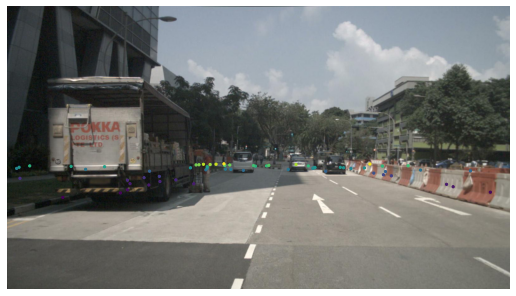

In [29]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT')

C:\Users\jadha\AppData\Local\Temp/ipykernel_21156/1904380112.py:27: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(sample_token)


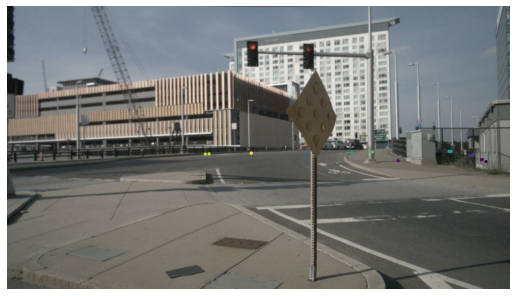

In [30]:
sample_token = nusc.get('sample_data', pointsensor_token)['sample_token']
pointsensor_channel = 'RADAR_FRONT'
camera_channel = 'CAM_FRONT'
sample_record = nusc.get('sample', sample_token)
ax = None
lidarseg_preds_bin_path = None
dot_size = 5
out_path = None
verbose = True

# Here we just grab the front camera and the point sensor.
pointsensor_token = sample_record['data'][pointsensor_channel]
camera_token = sample_record['data'][camera_channel]

# points, coloring, im = map_pointcloud_to_image(pointsensor_token, camera_token,
#                                                     render_intensity=render_intensity,
#                                                     show_lidarseg=show_lidarseg,
#                                                     filter_lidarseg_labels=filter_lidarseg_labels,
#                                                     lidarseg_preds_bin_path=lidarseg_preds_bin_path)

# Init axes.
if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(9, 16))
    if lidarseg_preds_bin_path:
        fig.canvas.set_window_title(sample_token + '(predictions)')
    else:
        fig.canvas.set_window_title(sample_token)
else:  # Set title on if rendering as part of render_sample.
    ax.set_title(camera_channel)
ax.imshow(im)
ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
ax.axis('off')

# Produce a legend with the unique colors from the scatter.
if pointsensor_channel == 'LIDAR_TOP' and show_lidarseg and show_lidarseg_legend:
    # Since the labels are stored as class indices, we get the RGB colors from the colormap in an array where
    # the position of the RGB color corresponds to the index of the class it represents.
    color_legend = colormap_to_colors(self.nusc.colormap, self.nusc.lidarseg_name2idx_mapping)

            # If user does not specify a filter, then set the filter to contain the classes present in the pointcloud
            # after it has been projected onto the image; this will allow displaying the legend only for classes which
            # are present in the image (instead of all the classes).
    if filter_lidarseg_labels is None:
        filter_lidarseg_labels = get_labels_in_coloring(color_legend, coloring)

    create_lidarseg_legend(filter_lidarseg_labels,
                            self.nusc.lidarseg_idx2name_mapping, self.nusc.colormap)

if out_path is not None:
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0, dpi=200)
if verbose:
    plt.show()


In [31]:
nusc = NuScenes(dataroot='C:\\Users\\jadha\\Machine Perception and Intelligence\\NuScenes\\data\\sets\\nuscenes')
camera_token = 'e3d495d4ac534d54b321f50006683844'
pointsensor_token ='9d9bf11fb0e144c8b446d54a8a00184f'

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.600 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [32]:
cam = nusc.get('sample_data', camera_token)
pointsensor = nusc.get('sample_data', pointsensor_token)
pcl_path = osp.join(nusc.dataroot, pointsensor['filename'])
print(pcl_path)


if pointsensor['sensor_modality'] == 'lidar':
    if show_lidarseg:
        assert hasattr(nusc, 'lidarseg'), 'Error: nuScenes-lidarseg not installed!'

                # Ensure that lidar pointcloud is from a keyframe.
        assert pointsensor['is_key_frame'], \
            'Error: Only pointclouds which are keyframes have lidar segmentation labels. Rendering aborted.'

        assert not render_intensity, 'Error: Invalid options selected. You can only select either ' \
                                        'render_intensity or show_lidarseg, not both.'

    pc = LidarPointCloud.from_file(pcl_path)
else:
    pc = RadarPointCloud.from_file(pcl_path)
im = Image.open(osp.join(nusc.dataroot, cam['filename']))

# Points live in the point sensor frame. So they need to be transformed via global to the image plane.
# First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
pc.translate(np.array(cs_record['translation']))

# Second step: transform from ego to the global frame.
poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
pc.translate(np.array(poserecord['translation']))

# Third step: transform from global into the ego vehicle frame for the timestamp of the image.
poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
pc.translate(-np.array(poserecord['translation']))
pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

# Fourth step: transform from ego into the camera.
cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
pc.translate(-np.array(cs_record['translation']))
pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

# Fifth step: actually take a "picture" of the point cloud.
# Grab the depths (camera frame z axis points away from the camera).
depths = pc.points[2, :]


C:\Users\jadha\Machine Perception and Intelligence\NuScenes\data\sets\nuscenes\samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin


In [33]:
if render_intensity:
    assert pointsensor['sensor_modality'] == 'lidar', 'Error: Can only render intensity for lidar, ' \
                                                        'not %s!' % pointsensor['sensor_modality']
    # Retrieve the color from the intensities.
    # Performs arbitary scaling to achieve more visually pleasing results.
    intensities = pc.points[3, :]
    intensities = (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))
    intensities = intensities ** 0.1
    intensities = np.maximum(0, intensities - 0.5)
    coloring = intensities
elif show_lidarseg:
    assert pointsensor['sensor_modality'] == 'lidar', 'Error: Can only render lidarseg labels for lidar, ' \
                                                        'not %s!' % pointsensor['sensor_modality']

    if lidarseg_preds_bin_path:
        sample_token = self.nusc.get('sample_data', pointsensor_token)['sample_token']
        lidarseg_labels_filename = lidarseg_preds_bin_path
        assert os.path.exists(lidarseg_labels_filename), \
            'Error: Unable to find {} to load the predictions for sample token {} (lidar ' \
            'sample data token {}) from.'.format(lidarseg_labels_filename, sample_token, pointsensor_token)
    else:
        if len(self.nusc.lidarseg) > 0:  # Ensure lidarseg.json is not empty (e.g. in case of v1.0-test).
            lidarseg_labels_filename = osp.join(self.nusc.dataroot,
                                                self.nusc.get('lidarseg', pointsensor_token)['filename'])
        else:
            lidarseg_labels_filename = None

    if lidarseg_labels_filename:
        # Paint each label in the pointcloud with a RGBA value.
        coloring = paint_points_label(lidarseg_labels_filename, filter_lidarseg_labels,
                                        self.nusc.lidarseg_name2idx_mapping, self.nusc.colormap)
    else:
        coloring = depths
        print('Warning: There are no lidarseg labels in {}. Points will be colored according to distance '
                'from the ego vehicle instead.'.format(self.nusc.version))
else:
    # Retrieve the color from the depth.
    coloring = depths

# Take the actual picture (matrix multiplication with camera-matrix + renormalization).
points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

# Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
# Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
# casing for non-keyframes which are slightly out of sync.
mask = np.ones(depths.shape[0], dtype=bool)
mask = np.logical_and(mask, depths > min_dist)
mask = np.logical_and(mask, points[0, :] > 1)
mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
mask = np.logical_and(mask, points[1, :] > 1)
mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
points = points[:, mask]
coloring = coloring[mask]



In [34]:
NuScenes.calibrated_sensor = nusc.__load_table__('calibrated_sensor')

print('Calibration Info\n')
for k, v in NuScenes.calibrated_sensor[100].items():
    print('{} :{}'.format(k, v))
    
print('\nCalibration Info Between LiDAR and CAMERA\n')
print(NuScenes.calibrated_sensor)

Calibration Info

token :df8ef740e8f54ba6b9010eed67bbd051
sensor_token :5c29dee2f70b528a817110173c2e71b9
translation :[-0.562, -0.618, 0.53]
rotation :[0.0339401344459428, 0.0, 0.0, -0.9994238676726663]
camera_intrinsic :[]

Calibration Info Between LiDAR and CAMERA

[{'token': 'f4d2a6c281f34a7eb8bb033d82321f79', 'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a', 'translation': [3.412, 0.0, 0.5], 'rotation': [0.9999984769132877, 0.0, 0.0, 0.0017453283658983088], 'camera_intrinsic': []}, {'token': '2ee327ac0903407dbb42c754861c1e63', 'sensor_token': '1f69f87a4e175e5ba1d03e2e6d9bcd27', 'translation': [2.422, 0.8, 0.78], 'rotation': [0.7171539204983457, 0.0, 0.0, 0.6969148113750004], 'camera_intrinsic': []}, {'token': '341ad78c836f4dc4bd2c61ad12285a63', 'sensor_token': '232a6c4dc628532e81de1c57120876e9', 'translation': [2.422, -0.8, 0.77], 'rotation': [0.7010337393110511, 0.0, 0.0, -0.7131281065471795], 'camera_intrinsic': []}, {'token': '794da4b758054140bd84d26b1146e46e', 'sensor_token':

C:\Users\jadha\AppData\Local\Temp/ipykernel_21156/1094739105.py:27: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(sample_token)


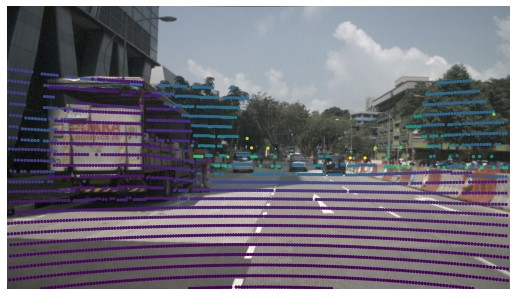

In [35]:
sample_token = nusc.get('sample_data', pointsensor_token)['sample_token']
pointsensor_channel = 'LIDAR_TOP'
camera_channel = 'CAM_FRONT'
sample_record = nusc.get('sample', sample_token)
ax = None
lidarseg_preds_bin_path = None
dot_size = 5
out_path = None
verbose = True

# Here we just grab the front camera and the point sensor.
pointsensor_token = sample_record['data'][pointsensor_channel]
camera_token = sample_record['data'][camera_channel]

# points, coloring, im = map_pointcloud_to_image(pointsensor_token, camera_token,
#                                                     render_intensity=render_intensity,
#                                                     show_lidarseg=show_lidarseg,
#                                                     filter_lidarseg_labels=filter_lidarseg_labels,
#                                                     lidarseg_preds_bin_path=lidarseg_preds_bin_path)

# Init axes.
if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(9, 16))
    if lidarseg_preds_bin_path:
        fig.canvas.set_window_title(sample_token + '(predictions)')
    else:
        fig.canvas.set_window_title(sample_token)
else:  # Set title on if rendering as part of render_sample.
    ax.set_title(camera_channel)
ax.imshow(im)
ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
ax.axis('off')

# Produce a legend with the unique colors from the scatter.
if pointsensor_channel == 'LIDAR_TOP' and show_lidarseg and show_lidarseg_legend:
    # Since the labels are stored as class indices, we get the RGB colors from the colormap in an array where
    # the position of the RGB color corresponds to the index of the class it represents.
    color_legend = colormap_to_colors(self.nusc.colormap, self.nusc.lidarseg_name2idx_mapping)

            # If user does not specify a filter, then set the filter to contain the classes present in the pointcloud
            # after it has been projected onto the image; this will allow displaying the legend only for classes which
            # are present in the image (instead of all the classes).
    if filter_lidarseg_labels is None:
        filter_lidarseg_labels = get_labels_in_coloring(color_legend, coloring)

    create_lidarseg_legend(filter_lidarseg_labels,
                            self.nusc.lidarseg_idx2name_mapping, self.nusc.colormap)

if out_path is not None:
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0, dpi=200)
if verbose:
    plt.show()

